# Exam Score Prediction using Machine Learning

This project predicts students' exam scores based on study habits,
attendance, lifestyle, and academic factors.


In [101]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [103]:
# Load dataset

df=pd.read_csv('Exam_Score_Prediction.csv')

In [105]:
# Basic Data Understanding

df.shape

(20000, 13)

In [107]:
df.columns


Index(['student_id', 'age', 'gender', 'course', 'study_hours',
       'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality',
       'study_method', 'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [109]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


## Dataset Overview

The dataset contains **20,000 student records** with **13 features**, including
demographic, academic, and lifestyle factors. The target variable is
**exam_score**.

The dataset includes both **numerical and categorical variables**, making it
suitable for **regression analysis** with proper preprocessing. No missing
values were observed, indicating **good data quality**.


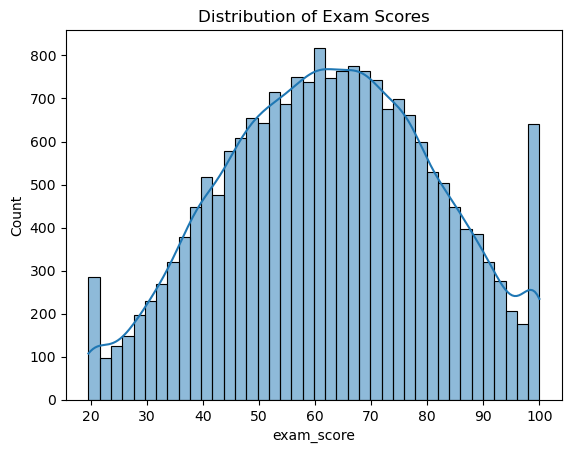

In [111]:
# Target Variable Distribution

sns.histplot(df['exam_score'],kde=True)
plt.title("Distribution of Exam Scores")
plt.show()

In [113]:
# Missing & Duplicate Check

df.isnull().sum()
df.duplicated().sum()

0

In [115]:
# Separate Numerical & Categorical Columns

num_cols=df.select_dtypes(include=['int64','float64']).columns.drop('student_id')
cat_cols=df.select_dtypes(include='object').columns

num_cols,cat_cols

(Index(['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score'], dtype='object'),
 Index(['gender', 'course', 'internet_access', 'sleep_quality', 'study_method',
        'facility_rating', 'exam_difficulty'],
       dtype='object'))

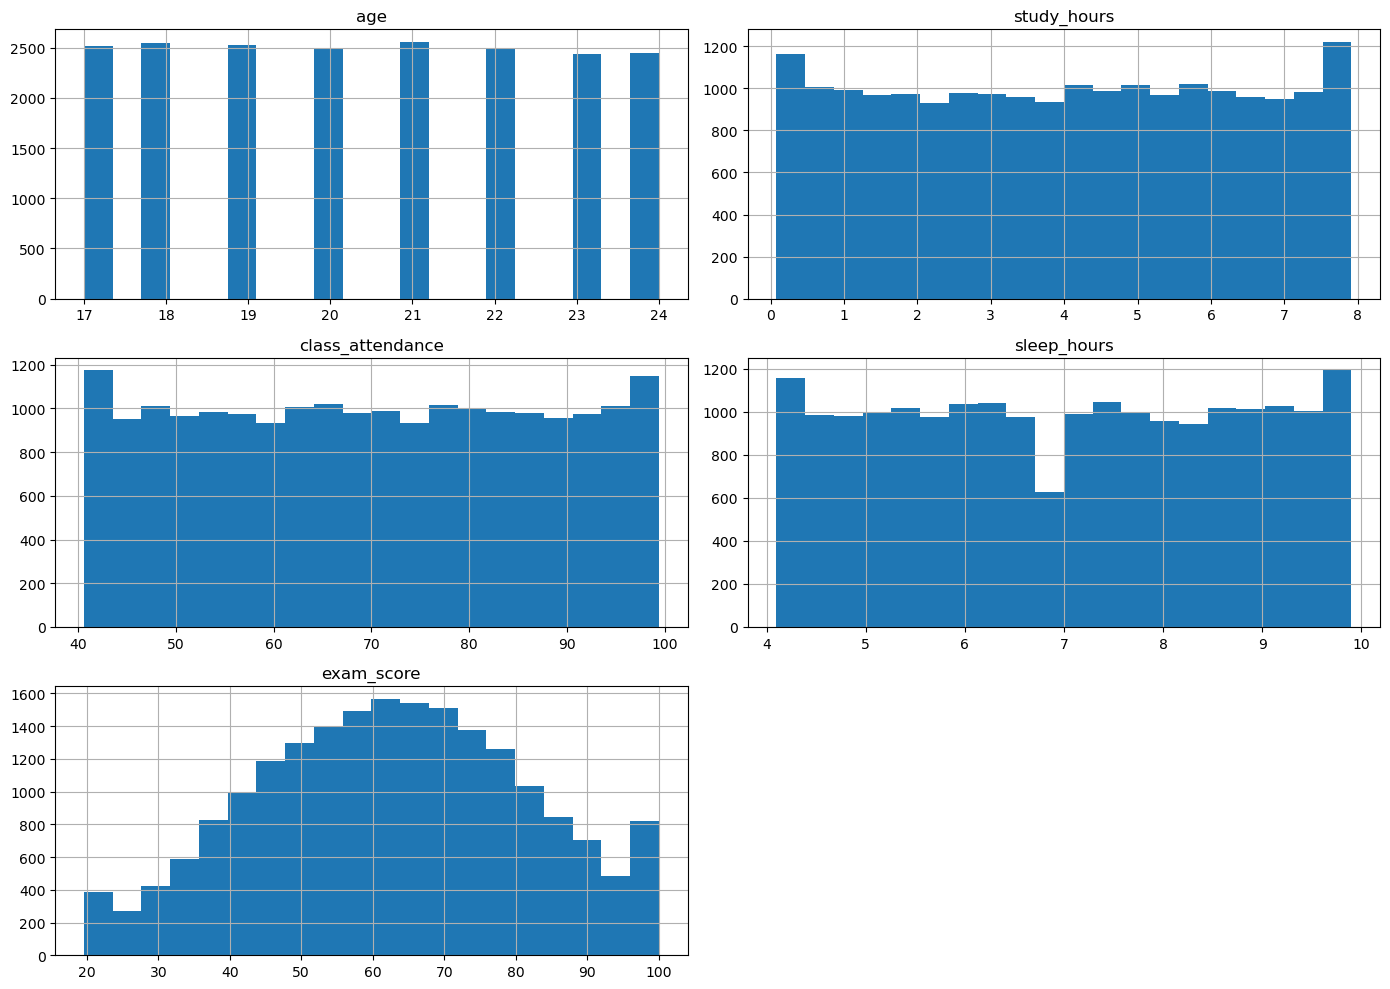

In [117]:
df[num_cols].hist(bins=20,figsize=(14,10))
plt.tight_layout()
plt.show()

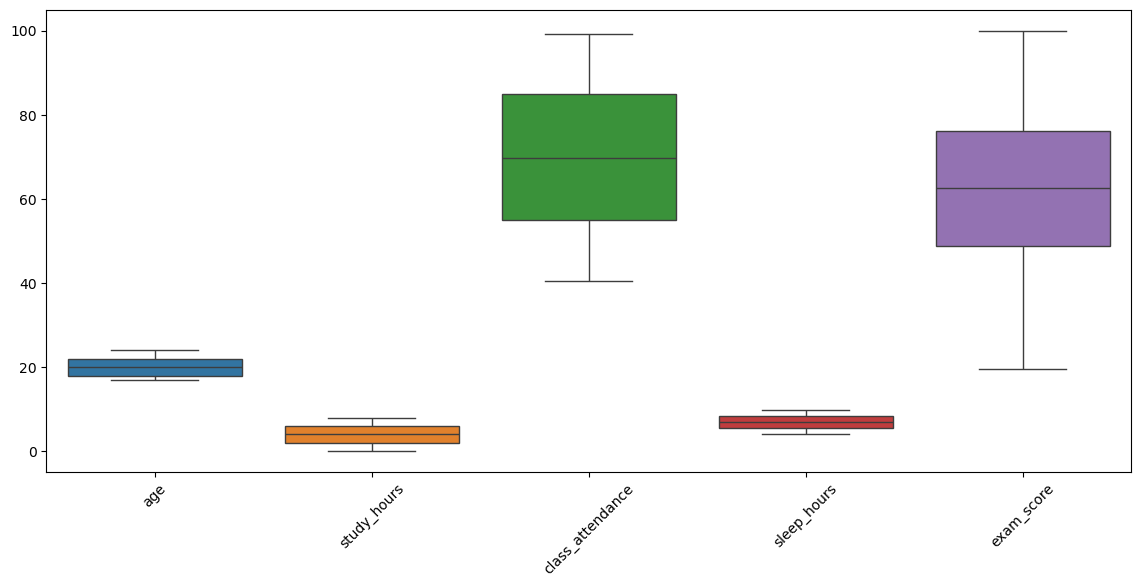

In [119]:
# Boxplots (Outlier Detection)

plt.figure(figsize=(14,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.show()

In [123]:
# Correlation with Target

df[num_cols].corr()['exam_score'].sort_values(ascending=False)

exam_score          1.000000
study_hours         0.717788
class_attendance    0.308850
sleep_hours         0.133222
age                 0.006522
Name: exam_score, dtype: float64

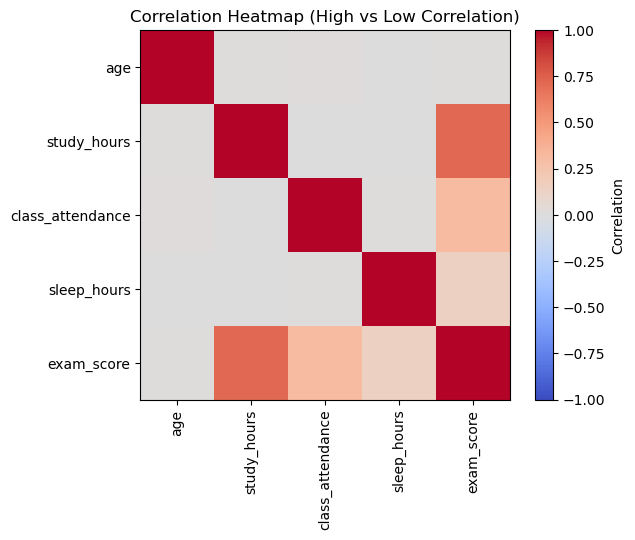

In [125]:
corr = df[num_cols].corr()

plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap (High vs Low Correlation)")
plt.show()

In [127]:
# Binary encoding

df['internet_access']=df['internet_access'].map({'yes':1,'no':0})

In [129]:
# Ordinal Encoding

ordinal_cols=['sleep_quality','exam_difficulty','facility_rating']
ordinal_maps={'sleep_quality':{'poor':0,'average':1,'good':3},
              'exam_difficulty':{'easy':0,'moderate':1,'hard':2},
              'facility_rating':{'low':0,'medium':1,'high':2}
             }
for col in ordinal_cols:
     df[col] = df[col].astype(str).str.lower().str.strip()
     df[col] = df[col].map(ordinal_maps[col])
     df[col] = df[col].fillna(0).astype(int)

In [131]:
# Polynomial / Interaction Features

from sklearn.preprocessing import PolynomialFeatures
numeric_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
poly_cols = numeric_cols + ordinal_cols  # include ordinal columns

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df[poly_cols])

# readable column names
poly_feature_names = [name.replace(' ', '*').replace('**2','^2') 
                      for name in poly.get_feature_names_out(poly_cols)]

df_poly = pd.DataFrame(poly_data, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

In [133]:
# One-Hot Encoding for Multi-Class Categoricals

multi_cat_cols = ['course', 'study_method','gender']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

print("Final dataframe shape:", df.shape)

Final dataframe shape: (20000, 57)


In [135]:
df.head(10)

,student_id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,...,course_ba,course_bba,course_bca,course_diploma,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,gender_male,gender_other
0,1,17,2.78,92.9,1,7.4,0,0,2,58.9,...,False,False,False,True,False,False,False,False,True,False
1,2,23,3.37,64.8,1,4.6,1,1,1,54.8,...,False,False,True,False,False,False,True,False,False,True
2,3,22,7.88,76.8,1,8.5,0,2,1,90.3,...,False,False,False,False,False,False,False,False,True,False
3,4,20,0.67,48.4,1,5.8,1,0,1,29.7,...,False,False,False,True,False,False,True,False,False,True
4,5,20,0.89,71.6,1,9.8,0,0,1,43.7,...,False,False,False,True,False,False,False,False,False,False
5,6,23,3.48,65.4,1,4.2,3,0,1,58.2,...,False,False,False,False,False,True,False,False,True,False
6,7,17,1.35,69.0,1,7.4,1,2,2,53.7,...,False,False,False,False,False,False,True,False,False,False
7,8,22,5.48,51.1,1,8.2,0,0,1,47.3,...,False,False,False,False,False,False,False,True,True,False
8,9,18,2.89,92.0,1,6.6,0,0,0,44.9,...,False,False,True,False,False,False,False,True,False,True
9,10,17,6.77,44.8,1,9.8,1,2,1,77.7,...,False,True,False,False,True,False,False,False,True,False


In [137]:
# Train-Test split

X=df.drop('exam_score',axis=1)
y=df['exam_score']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [139]:
# Standardization

num_features=X_train.select_dtypes(include=['int64','float64']).columns
scaler=StandardScaler()
X_train[num_features]=scaler.fit_transform(X_train[num_features])
X_test[num_features]=scaler.transform(X_test[num_features])

In [141]:
# Baseline Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
lr_train_r2 = r2_score(y_train, y_pred_train_lr)
lr_test_r2 = r2_score(y_test, y_pred_test_lr)

print("Baseline Linear Regression")
print(f"Train RMSE: {lr_train_rmse:.3f}, Test RMSE: {lr_test_rmse:.3f}")
print(f"Train R²: {lr_train_r2:.3f}, Test R²: {lr_test_r2:.3f}")


Baseline Linear Regression
Train RMSE: 9.779, Test RMSE: 9.774
Train R²: 0.732, Test R²: 0.733


In [145]:
# Ridge WITHOUT tuning

from sklearn.linear_model import Ridge
ridge=Ridge(alpha=1.0)
ridge.fit(X_train,y_train)
y_pred_train_ridge=ridge.predict(X_train)
y_pred_test_ridge=ridge.predict(X_test)
ridge_train_rmse=np.sqrt(mean_squared_error(y_train,y_pred_train_ridge))
ridge_test_rmse=np.sqrt(mean_squared_error(y_test,y_pred_test_ridge))
ridge_train_r2=r2_score(y_train,y_pred_train_ridge)
ridge_test_r2=r2_score(y_test,y_pred_test_ridge)

print("Ridge Regression (alpha=1.0)")
print(f"Train RMSE: {ridge_train_rmse:.3f}, Test RMSE: {ridge_test_rmse:.3f}")
print(f"Train R²: {ridge_train_r2:.3f}, Test R²: {ridge_test_r2:.3f}")


Ridge Regression (alpha=1.0)
Train RMSE: 9.778, Test RMSE: 9.777
Train R²: 0.733, Test R²: 0.733


In [147]:
# Ridge with Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
ridge = Ridge()
param_grid={'alpha':[0.01,0.1,1,10,100]
           }
grid=GridSearchCV(
    ridge,param_grid,cv=5,scoring='r2'
)
grid.fit(X_train, y_train)

best_ridge = grid.best_estimator_

print("Best alpha:", grid.best_params_['alpha'])

y_pred_train_ridge_tuned = best_ridge.predict(X_train)
y_pred_test_ridge_tuned = best_ridge.predict(X_test)

ridge_train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_pred_train_ridge_tuned))
ridge_test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge_tuned))
ridge_train_r2_tuned = r2_score(y_train, y_pred_train_ridge_tuned)
ridge_test_r2_tuned = r2_score(y_test, y_pred_test_ridge_tuned)

print("Ridge Regression (Tuned)")
print(f"Train RMSE: {ridge_train_rmse_tuned:.3f}, Test RMSE: {ridge_test_rmse_tuned:.3f}")
print(f"Train R²: {ridge_train_r2_tuned:.3f}, Test R²: {ridge_test_r2_tuned:.3f}")

Best alpha: 10
Ridge Regression (Tuned)
Train RMSE: 9.778, Test RMSE: 9.777
Train R²: 0.733, Test R²: 0.733


## Model Comparison Note: (Baseline LR,  Ridge WITHOUT tuning, Ridge with Hyperparameter Tuning)

Linear Regression and Ridge Regression gave almost the same results. 
This shows that the data does not have strong feature overlap and the Linear Regression model is already working well. 
Ridge regularization helped confirm that the model is stable, but it did not improve the performance much.

In [151]:
# Baseline Random Forest (NO tuning)

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Random Forest (Baseline)")
print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

Random Forest (Baseline)
Train RMSE: 3.917, Test RMSE: 10.423
Train R²: 0.957, Test R²: 0.696


In [154]:
# Feature Importance (without tunning)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
24,study_hours*class_attendance,0.611361
40,sleep_quality*facility_rating,0.033614
30,class_attendance*sleep_hours,0.032340
0,student_id,0.024974
25,study_hours*sleep_hours,0.022758
31,class_attendance*sleep_quality,0.018888
26,study_hours*sleep_quality,0.017518
18,age*class_attendance,0.016433
28,study_hours*facility_rating,0.016071
19,age*sleep_hours,0.015610


In [156]:
# Hyperparameter Tuning – Random Forest
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [158]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 2}

In [160]:
best_rf = grid_search.best_estimator_

y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

In [162]:
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print("Tuned Random Forest")
print(f"Train RMSE: {rf_train_rmse:.3f}, Test RMSE: {rf_test_rmse:.3f}")
print(f"Train R²: {rf_train_r2:.3f}, Test R²: {rf_test_r2:.3f}")

Tuned Random Forest
Train RMSE: 8.186, Test RMSE: 10.310
Train R²: 0.813, Test R²: 0.703


In [166]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': [
        'Linear Regression (Baseline)',
        'Ridge Regression (No Tuning)',
        'Ridge Regression (Tuned)',
        'Random Forest (Baseline)',
        'Random Forest (Tuned)'
    ],
    'Train RMSE': [
        lr_train_rmse,
        ridge_train_rmse,
        ridge_train_rmse_tuned,
        train_rmse,
        rf_train_rmse
    ],
    'Test RMSE': [
        lr_test_rmse,
        ridge_test_rmse,
        ridge_test_rmse_tuned,
        test_rmse,
        rf_test_rmse
    ],
    'Train R²': [
        lr_train_r2,
        ridge_train_r2,
        ridge_train_r2_tuned,
        train_r2,
        rf_train_r2
    ],
    'Test R²': [
        lr_test_r2,
        ridge_test_r2,
        ridge_test_r2_tuned,
        test_r2,
        rf_test_r2
    ]
})

comparison_df


,Model,Train RMSE,Test RMSE,Train R²,Test R²
0,Linear Regression (Baseline),9.778915,9.774377,0.732484,0.732907
1,Ridge Regression (No Tuning),9.777875,9.776975,0.732540,0.732765
2,Ridge Regression (Tuned),9.778272,9.777171,0.732519,0.732754
3,Random Forest (Baseline),3.916802,10.423269,0.957083,0.696267
4,Random Forest (Tuned),8.186117,10.309874,0.812533,0.702839


# Conclusion

Linear and Ridge regression provide the best predictive performance on this dataset, with high stability and minimal overfitting. 
Random Forest, even after tuning, does not outperform linear models, likely because the underlying feature-target relationships are mostly linear.